# A/B Testing 

- [Introduction](#intro)
- [Part I - Data Inspection & Cleaning](#cleaning)
- [Part II - A/B Test](#ab_test)
- [Part III - Conclusion](#conclusion)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts to test for statistical significance between two means and whether a difference occurred by chance. For this project, I will be utilizing A/B testing to help the People Department of a fictitious company determine if their recruiting efforts are significantly different with application process 1 vs. application process 2.  

Scenario: The company is having trouble recruiting for an hourly position with a tight labor market and competitive wages and they want to ensure that the current application process is not dissuading applicants due to its complexity.  They have developed a new simplified application process and they want to test it to see if it helps to increase applications.  

For this analysis, application process 1 is the existing online process being used and will be the control group.  The new simplified online process - application process 2 - will be the treatment group.  Applicants during the test period were randomly directed from the company's career page to either the control group application page or to the treatment group application page to complete the process.  Converted (1) indicates that the user completed the application process, whereas (0) indicates that the user abandoned the process and did not submit an application.

In this project, the null hypothesis is that the rate of conversions for application process 1 is the same or better than that of application process 2.  The alternative hypothesis is that the conversion rate is higher for the new application process - the treatment group.  The goal of this analysis is to use statistics to reject/not reject the null hypothesis in order to assist the company in deciding which application process to use going forward.

*Note: Data sourced from Kaggle https://www.kaggle.com/datasets/zhangluyuan/ab-testing.  Data was modified to fit the needs of this analysis.*

<a id='cleaning'></a>
## Part I - Data Inspection & Cleaning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()
import scipy.stats as ss
import matplotlib.pyplot as plt
%matplotlib inline

First, I will read in the data using pandas and investigate the data to get some basic information and understanding.  

In [2]:
#read in data & view top rows
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,converted,hired
0,864975,1/21/17 10:11 PM,control,1,1
1,644214,1/12/17 8:01 AM,control,1,1
2,913579,1/11/17 4:55 PM,control,1,1
3,831737,1/8/17 6:28 PM,control,1,1
4,862225,1/21/17 1:52 AM,control,1,1


The data contains the following fields:  
<pre>
user_id   - unique id of the user that visited the company's career page
timestamp - the date and time the user visited the company's career page
group     - control indicates application process 1 and treatment indicates application process 2
converted - indicates whether the user submitted an application (1) or not (0)
hired     - additional data from HRMS indicating if candidate was ultimately hired
</pre>

In [3]:
#check data types
df.dtypes

user_id       int64
timestamp    object
group        object
converted     int64
hired         int64
dtype: object

In [4]:
#convert timestamp field to a timestamp data type
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.dtypes

user_id               int64
timestamp    datetime64[ns]
group                object
converted             int64
hired                 int64
dtype: object

In [5]:
#Calculate length of test in days
min_date = df['timestamp'].min()
max_date = df['timestamp'].max()
duration = (max_date - min_date) / pd.Timedelta(days=1)
duration

21.999305555555555

In [6]:
#get number of rows/columns
df.shape

(294478, 5)

In [7]:
#check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    294478 non-null  int64         
 1   timestamp  294478 non-null  datetime64[ns]
 2   group      294478 non-null  object        
 3   converted  294478 non-null  int64         
 4   hired      294478 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 11.2+ MB


In [8]:
#get number of unique users in dataset
df['user_id'].nunique()

290584

### Dealing with Duplicates
There are 290,584 unique user ids and 294,478 records, which means there are duplicate ids in the data.  The duplicate ids will be investigated to determine how to properly treat that data.

In [9]:
#create a subfile of duplicate records
dups = df[df['user_id'].duplicated(keep=False)]
dups_sorted = dups.sort_values(by='user_id')
dups_sorted.head(20)

,user_id,timestamp,group,converted,hired
30412,630052,2017-01-14 08:13:00,treatment,1,0
266199,630052,2017-01-12 11:57:00,treatment,0,0
275673,630126,2017-01-08 19:03:00,treatment,0,0
174614,630126,2017-01-07 03:25:00,treatment,0,0
115685,630137,2017-01-20 03:26:00,control,0,0
40437,630137,2017-01-02 23:31:00,control,0,0
126144,630320,2017-01-24 07:07:00,control,0,0
277448,630320,2017-01-14 16:33:00,treatment,0,0
77798,630471,2017-01-10 21:23:00,control,0,0
83850,630471,2017-01-19 05:04:00,control,0,0


In [10]:
#identify number of duplicate rows
dups_sorted.shape[0]

7788

What we can see from the above is that we have multiple situations: 

- Situation 1: The user visited the site multiple times and was erroneously sent to both the control process and the treatment process.  In order to ensure accuracy and not allow these records to skew the results, any users who saw both processes will be eliminated from the data.  
- Situation 2: The user visited the site multiple times; if they converted, it appears they did so on the most recent visit to the site.  So perhaps they visited the career page and looked at the job specifics, but then decided they needed to gather their application information before proceeding.  With 7,788 rows of duplicate data, we would need to investigate further to see if that assumption holds true.  For purposes of this analysis, we will assume that to be true and only keep the most recent visit.  Obviously, this will vary depending on the specifics of the situation.  

### Removing User Records for Situation 1

In [11]:
#create copy of dataframe to identify users who are in both the control and treatment groups
both = dups_sorted.copy()
both.head()

,user_id,timestamp,group,converted,hired
30412,630052,2017-01-14 08:13:00,treatment,1,0
266199,630052,2017-01-12 11:57:00,treatment,0,0
275673,630126,2017-01-08 19:03:00,treatment,0,0
174614,630126,2017-01-07 03:25:00,treatment,0,0
115685,630137,2017-01-20 03:26:00,control,0,0


In [12]:
#drop all columns except for user_id and group
both.drop(columns=['timestamp', 'converted', 'hired'], inplace=True)
both.head()

,user_id,group
30412,630052,treatment
266199,630052,treatment
275673,630126,treatment
174614,630126,treatment
115685,630137,control


In [13]:
#group by 'user_id' and aggregate the 'group' column to identify users in both groups
both_grouped = both.groupby('user_id')['group'].agg(lambda x: " OR ".join(set(x))).reset_index()
both_grouped.head()

,user_id,group
0,630052,treatment
1,630126,treatment
2,630137,control
3,630320,control OR treatment
4,630471,control


In [14]:
#filter to only those that have a record in both groups
both_grouped = both_grouped[both_grouped['group'].str.contains("control OR treatment|treatment OR control")]

#drop group column
both_grouped.drop(columns=['group'], inplace=True)
both_grouped.head()

,user_id
3,630320
7,630805
8,630871
9,630887
10,631008


In [15]:
#check count of rows to remove (result x 2)
both_grouped.shape[0]

1895

In [16]:
#re-check number of rows in original dataframe
df.shape[0]

294478

In [17]:
#merge on user_id with those matching indicated with "both"; dataframe is then filtered to remove "both"
df_filtered = (
    df.merge(both_grouped, 
              on=['user_id'],
              how='left', 
              indicator=True)
    .query('_merge != "both"')
    .drop(columns='_merge')
)
df_filtered.head()

,user_id,timestamp,group,converted,hired
0,864975,2017-01-21 22:11:00,control,1,1
1,644214,2017-01-12 08:01:00,control,1,1
2,913579,2017-01-11 16:55:00,control,1,1
3,831737,2017-01-08 18:28:00,control,1,1
4,862225,2017-01-21 01:52:00,control,1,1


In [18]:
#check number of rows in filtered dataframe to confirm removal of records
df_filtered.shape[0]

290688

1,895 user ids were identified as having been sent to both the control and the treatment process pages.  That means that 3,790 records needed to be removed from the original dataframe and it was confirmed that the new, filtered dataframe contains 290,688 records which is 3,790 less that the original 294,478 records.

### Removing User Records for Situation 2

In [19]:
#check number of duplicate user ids remaining
df_filtered['user_id'].duplicated().sum()

1999

In [20]:
#sort records by user id and timestamp in ascending order so that newest record is on top
df_filtered = df_filtered.sort_values(by=['user_id', 'timestamp'], ascending=False)
df_filtered.head(30)

,user_id,timestamp,group,converted,hired
269163,945999,2017-01-22 03:35:00,treatment,0,0
141180,945998,2017-01-15 10:37:00,control,0,0
83284,945997,2017-01-05 06:59:00,control,0,0
286232,945996,2017-01-15 03:42:00,treatment,0,0
155809,945994,2017-01-15 16:19:00,control,0,0
107276,945993,2017-01-10 22:37:00,control,0,0
75891,945992,2017-01-19 00:25:00,control,0,0
10689,945991,2017-01-19 16:02:00,control,1,0
67771,945990,2017-01-11 08:19:00,control,0,0
21865,945989,2017-01-03 04:27:00,treatment,1,0


In [21]:
#re-check number of records in dataframe
df_filtered.shape[0]

290688

In [22]:
#drop duplicate user id records keeping first record
df_filtered = df_filtered.drop_duplicates(subset=['user_id'], keep='first')
df_filtered.shape[0]

288689

In [23]:
#check specific user id 945971 to confirm removal of correct record
user_check = df_filtered.query('user_id == 945971')
user_check

,user_id,timestamp,group,converted,hired
107654,945971,2017-01-07 08:01:00,control,0,0


For the second situation, 1,999 duplicate records wered identified as needing to be removed. As the decision was made to keep the most recent record, the timestamp was sorted in ascending order before removing the duplicates and specifying that the first record should be kept.  This action was confirmed by looking specifically at user id 945971.  Prior to removing the duplicates, we can see that the user has two records: one on 1/6/2017 and one on 1/7/2017.  It was confirmed that the correct records was kept - the record from 1/7/2017. 

In [24]:
#confirm no further duplicates in the dataframe
df_filtered.duplicated().sum()

0

### Basic EDA

In [25]:
#count number of users in control group
control = df_filtered.query('group == "control"')['group'].count()
control

144300

In [26]:
#calculate proportion of control group
control_pro = control / df_filtered.shape[0]
control_pro

0.49984585488189714

In [27]:
#count number of user in treatment group
treatment = df_filtered.query('group == "treatment"')['group'].count()
treatment

144389

In [28]:
#calculate proportion of treatment group
treatment_pro = treatment / df_filtered.shape[0]
treatment_pro

0.5001541451181029

The above confirms that the percentage of users in each group is relatively equal.  This is important because the a/b test will reach statistical significance quicker when the groups are equal in size.

In [29]:
#calculate overall conversion rate
convert_rate = df_filtered.query('converted == 1')['user_id'].count() / df_filtered.shape[0]
convert_rate

0.11959236410116077

In [30]:
#calculate conversion rate for control
control_prob = df_filtered.query('group == "control"')['converted'].mean()
control_prob

0.12036729036729037

In [31]:
#calculate conversion rate for treatment
treatment_prob = df_filtered.query('group == "treatment"')['converted'].mean()
treatment_prob

0.11881791549217738

In [32]:
#calculate the actual difference (obs_diff) between conversion rates for the two groups.
obs_diff = treatment_prob - control_prob
obs_diff

-0.0015493748751129882

Based on the current test length of approximately 21 days, the treatment group conversion rate of 11.88% appears to be less than that of the control group which had a conversion rate of about 12.04%. The probability of being sent to the new application process was around 50%, so our groups appear to be evenly split between old process/control and new process/treatment.  It does not appear that the new page leads to more conversions, but further testing is recommended.

<a id='ab_test'></a>
## Part II - A/B Test



Prior to performing the A/B test, the daily conversion rates will need to be calculated.  The difference between the mean daily conversion rates in each group is what will be tested.  

In [33]:
# Group by 'day', 'group', and calculate mean 'converted'
grouped_df = df_filtered.groupby([df_filtered['timestamp'].dt.day, 'group'])['converted'].mean().reset_index()

# Pivot the DataFrame to get the desired format
daily_conversions = grouped_df.pivot(index='timestamp', columns='group', values='converted').reset_index()

# Rename the columns for clarity
daily_conversions.columns = ['day', 'control_conversion', 'treatment_conversion']

# Display the result
print(daily_conversions)

    day  control_conversion  treatment_conversion
0     2            0.126478              0.125176
1     3            0.114997              0.119654
2     4            0.123985              0.118216
3     5            0.113693              0.113822
4     6            0.118982              0.126599
5     7            0.119276              0.113050
6     8            0.121231              0.121624
7     9            0.121828              0.122477
8    10            0.128482              0.115209
9    11            0.123435              0.123896
10   12            0.122831              0.114321
11   13            0.125038              0.116659
12   14            0.118358              0.115774
13   15            0.120504              0.116829
14   16            0.118585              0.122273
15   17            0.118403              0.116431
16   18            0.120777              0.119380
17   19            0.111060              0.123993
18   20            0.122807              0.115396


To reiterate, the null hypothesis for this test is that the conversion rate for the old application process 1 (control group) is the same or better than the new application process 2 (treatment group).  The following plots show the distribution of the conversion rates for the control and treatment groups.

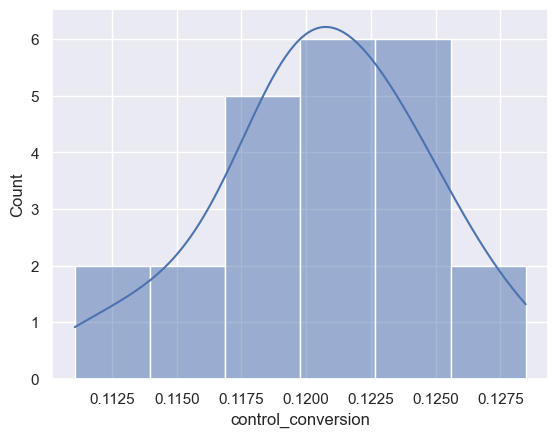

In [34]:
#plot distribution of control conversion rates
sns.histplot(daily_conversions.control_conversion, kde=True)
plt.show()

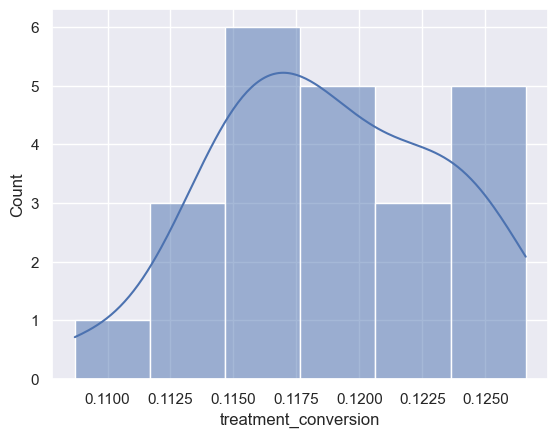

In [35]:
#plot distribution of treatment conversion rates
sns.histplot(daily_conversions.treatment_conversion, kde=True)
plt.show()

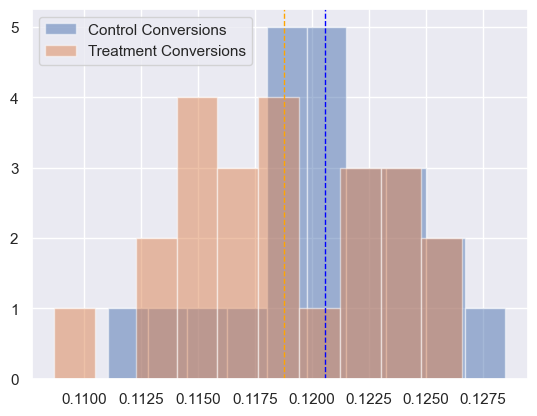

In [36]:
# Calculating the means
mean_control = np.mean(daily_conversions.control_conversion)
mean_treatment = np.mean(daily_conversions.treatment_conversion)

# Plotting the data with mean lines showing difference in means for each group
plt.hist(daily_conversions.control_conversion, alpha=0.5, label='Control Conversions')
plt.hist(daily_conversions.treatment_conversion, alpha=0.5, label='Treatment Conversions')
plt.axvline(mean_control, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(mean_treatment, color='orange', linestyle='dashed', linewidth=1)
plt.legend(loc='upper left')
plt.show()

In order to determine if the null hypothesis should be rejected or not, statistical significance must be proved.  In this way, we can know that the difference seen is not due to error or random chance.  In order to determine statistical significance, the two-sample t-test will be used.  The t-test is an appropriate test because, in this case, we do not know the population variance and because our sample size (days) is small (<30).  

In [37]:
#perform t-test to get t
t_stat, p_val = ss.ttest_ind(daily_conversions.treatment_conversion, daily_conversions.control_conversion)
t_stat, p_val

(-1.4376161989736334, 0.15761726431277076)

<a id='conclusion'></a>
### Part III - Conclusion


The p-value indicates the probability that the difference between two values is due to random chance.  A smaller p-value points to rejecting the null hypothesis, while a larger p-value indicates a failure to reject the null hypothesis.  In general practice, a significance level of 0.05 is used, meaning that if the p-value is less than 0.05, we would reject the null hypothesis.  

In this case, the p-value is not significant and higher than the 0.05 error rate (0.1576); therefore, we have failed to reject the null hypothesis.  There is insufficient evidence to conclude that the new application process is better than the existing application process.  From a practical standpoint, the cost of implementing the new application process seems greater than any benefit received, thus, the recommendation would be to keep the current application process in place.